# Creating the 4 panel z-test figure!


In [1]:
import confirm.outlaw.nb_util as nb_util

nb_util.setup_nb()
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from numpy import sqrt
import jax

## Exploration

We're going to produce a bound with the form:

$$
P(f(\mu) < U(\mu)) > 1 - \delta
$$

Where $f(\mu)$ is our error function and $U(\mu)$ is an upper bound on that function. Constructing the bound from Taylor series centered at several different points, `mu`.

In [2]:
delta = 0.01
z_thresh = 1.96
npts = 2
a = -1
b = 0
np.random.seed(9)

mu = np.linspace(a, b, 2 * npts + 1)[1::2]
stepsize = mu[1] - mu[0]
mu

array([-0.75, -0.25])

The test we'll be checking is `z > z_thresh`. For `z_thresh` equal to approximately 1.96, this gives a Type I Error rate of 2.5%.

In [3]:
z_thresh = -jax.scipy.stats.norm.ppf(0.025)
true_err = lambda mu: 1 - jax.scipy.stats.norm.cdf(-mu + z_thresh)
true_err(0), z_thresh

(DeviceArray(0.025, dtype=float64), DeviceArray(1.95996398, dtype=float64))

In [43]:
z_thresh

DeviceArray(1.95996398, dtype=float64)

Using JAX, we can compute the true gradient and hessian for this error function:

In [4]:
# these gradients are equivalent
true_gradient = jax.vmap(jax.grad(true_err))
true_gradient2 = lambda mu: jax.scipy.stats.norm.pdf(-mu + z_thresh)
true_second = jax.vmap(jax.grad(jax.grad(true_err)))
true_err(mu), true_gradient(mu), true_gradient2(mu), true_second(mu)

(DeviceArray([0.00336453, 0.01355383], dtype=float64),
 DeviceArray([0.01014382, 0.0347037 ], dtype=float64),
 DeviceArray([0.01014382, 0.0347037 ], dtype=float64),
 DeviceArray([0.02748938, 0.07669393], dtype=float64))

But, we can also compute the Type I Error and its gradient (with respect to
$\mu$) via simulation. Computing with simulation is much more robust and will
work well for more complex designs. And with just 10,000 simulations, the match between true error and estimated error is quite good!

In [5]:
# simulating the rejection/type I error
nsims = 100000
samples = np.random.normal(mu[:,None], 1, size=(mu.shape[0], nsims,))
reject = samples > z_thresh
typeI_sum = np.sum(reject, axis=-1)
typeI_est = typeI_sum / nsims
typeI_est, true_err(mu)

(DeviceArray([0.00355, 0.01374], dtype=float64),
 DeviceArray([0.00336453, 0.01355383], dtype=float64))

In addition, we can compute a gradient from the simulations.

From our theory of exponential families, the gradient estimate should be:

$$
\widehat{f'} = \frac{1}{n} \sum_j F_j (T(Z_j) - \nabla A(\theta_j)) 
$$

but, for a normal family: 

$$
A(\mu) = \mu^2 / (2\sigma^2) \mathrm{~~~and~~~} \sigma = 1
$$

so 

$$\nabla A(\mu) = \mu$$

and 

$$
T(Z_j) = Z_j / \sigma = Z_j
$$

So our estimate of $\hat{\nabla f}$ should be:

$$
\widehat{\nabla f} = \frac{1}{n} \sum_j F_j (Z_j - \mu_j))
$$ 

This estimated gradient is also quite close to the true gradient!

In [6]:
grad_est = np.sum(reject * (samples - mu[:, None]), axis=-1) / nsims
true_gradient(mu), grad_est

(DeviceArray([0.01014382, 0.0347037 ], dtype=float64),
 DeviceArray([0.01088418, 0.03502609], dtype=float64))

We can also construct a Clopper-Pearson confidence interval on the Type I Error estimate because the estimate is constructed as a sum of indicator variables.

In [7]:
typeI_CI = scipy.stats.beta.ppf(1 - delta, typeI_sum + 1, nsims - typeI_sum) - typeI_est
typeI_CI

DeviceArray([0.00046265, 0.0008808 ], dtype=float64)

And for the gradient term, we can construct a confidence interval using Chebyshev's inequality. 

Starting from Chebyshev and assuming $\widehat{f'}$ is unbiased (that is, $E(\widehat{f'}) = f'$):

$$
P( \widehat{f'} - f' | \leq k\sigma_{\widehat{f'}}) \geq 1 - \frac{1}{k^2}
$$

Equating the right hand sides:

$$
1 - \frac{1}{k^2} = 1 - \delta \mathrm{~~~~ gives ~~~~} k = \sqrt{\frac{1}{\delta}}
$$

From our theory of exponential families, we also know that:
$$
\sigma_{\hat{f}} \leq \sqrt{\frac{\nabla^2 A}{N}} = \sqrt{\frac{1}{N}}
$$

That gives:
$$
P\Bigg(| \widehat{f'} - f' | \leq \sqrt{\frac{1}{N\delta}}\Bigg) \geq 1 - \delta
$$

This is slightly looser than the version in the paper.

Deriving a *one-sided* bound starting from Cantelli's inequality get me the slightly tighter, but only-upper bound:

\begin{align}
P(\widehat{f'} + \lambda \leq f') \leq \delta = \frac{\sigma^2}{\sigma^2 + \lambda^2}\\
\lambda = \sqrt{\frac{1}{N}\Big(\frac{1}{\delta} - 1\Big)}\\
P\Bigg(\widehat{f'} + \sqrt{\frac{1}{N}\Big(\frac{1}{\delta} - 1\Big)} \leq f' \Bigg) \leq \delta
\end{align}

Below, we use the two-sided version but the difference is negligible when $\delta = 0.01$

In [8]:
chebyshev = np.sqrt(1 / (delta * nsims))
cantelli = np.sqrt(1 / nsims * (1 / delta - 1))
grad_est, chebyshev, cantelli

(DeviceArray([0.01088418, 0.03502609], dtype=float64),
 0.03162277660168379,
 0.03146426544510455)

Finally, also from exponential family theory, we can upper bound the hessian for the Type I Error for this test. The Type I Error must satisfy $|f''| \leq Var[X] = 1$ uniformly.

In fact, we can use numerical optimization to show that this bound is loose. But, for a fully general bound, the bound is sufficient. 


In [9]:
# the actual uniform upper bound on the second order term is ~0.2419707
# and occurs at N(x = 1, mu = 0, sig = 1) because x * np.exp(-0.5 * x ** 2) is
# maximized at x = 1
hess_bound_true = -scipy.optimize.minimize(lambda x: -true_second(x), 0).fun

# we can check the variance explicitly. note that the variance won't change
# with different values of mu because the whole integrand is just translated by
# mu.
explicit_integral = scipy.integrate.quad(
    lambda x: scipy.stats.norm.pdf(x, 0) * (x - 0) ** 2, 
    -10, 
    10
)
hess_bound = explicit_integral[0]
hess_bound_true, explicit_integral

(0.2419707245186588, (1.0, 7.348032512316527e-10))

To demonstrate all this, we'll make three plots:
1. The 0th order CIs alone.

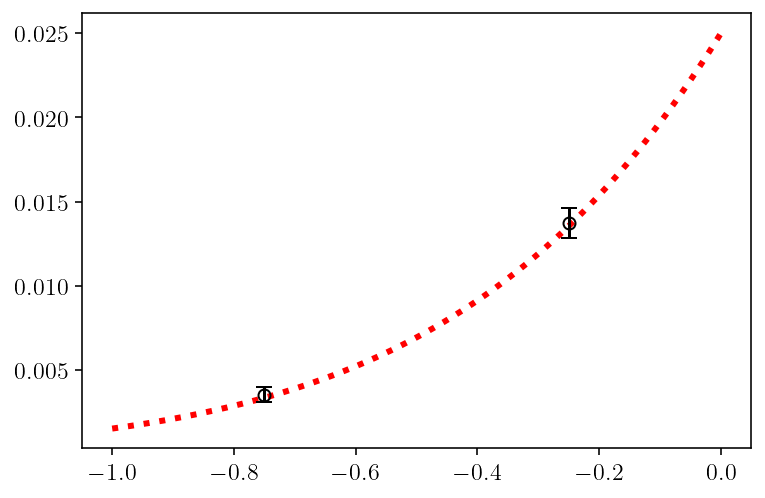

In [10]:
xs = np.linspace(-1, 0, 1000)

plt.plot(xs, true_err(xs), 'r:', linewidth=3)
plt.errorbar(
    mu,
    typeI_est,
    yerr=typeI_CI,
    ecolor="k",
    fmt="o",
    capsize=4,
    markeredgecolor="k",
    markerfacecolor="none",
)
plt.show()



2. The 0th and 1st order CIs.

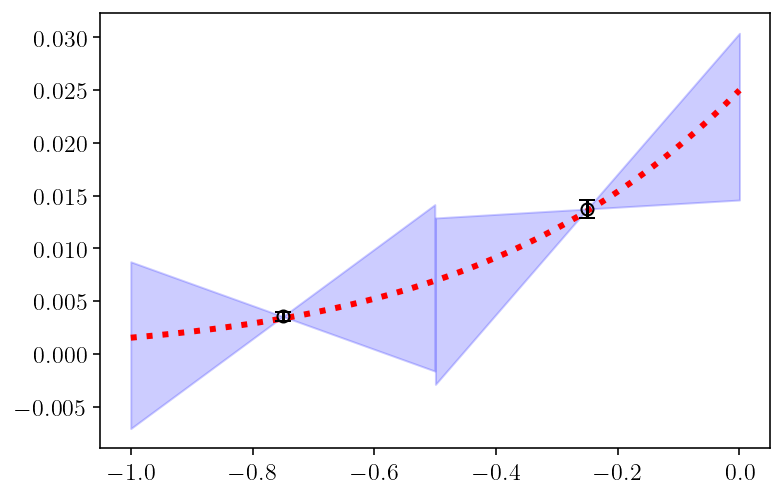

In [11]:
closest_mu_idx = np.abs(xs[:, None] - mu[None, :]).argmin(axis=-1)
v = xs - mu[closest_mu_idx]
grad_bounds = np.array([
    v * (grad_est[closest_mu_idx] + chebyshev),
    v * (grad_est[closest_mu_idx] - chebyshev)
])
max_1st_order = np.max(grad_bounds, axis=0)
min_1st_order = np.min(grad_bounds, axis=0)

plt.plot(xs, true_err(xs), 'r:', linewidth=3)
plt.errorbar(
    mu,
    typeI_est,
    yerr=typeI_CI,
    ecolor="k",
    fmt="o",
    capsize=4,
    markeredgecolor="k",
    markerfacecolor="none",
)
bound_hi = typeI_est[closest_mu_idx] + max_1st_order
bound_lo = typeI_est[closest_mu_idx] + min_1st_order
for i in range(len(mu)):
    select = closest_mu_idx == i
    plt.fill_between(xs[select], bound_lo[select], bound_hi[select], color='b', alpha=0.2)
plt.show()

3. The full bound.

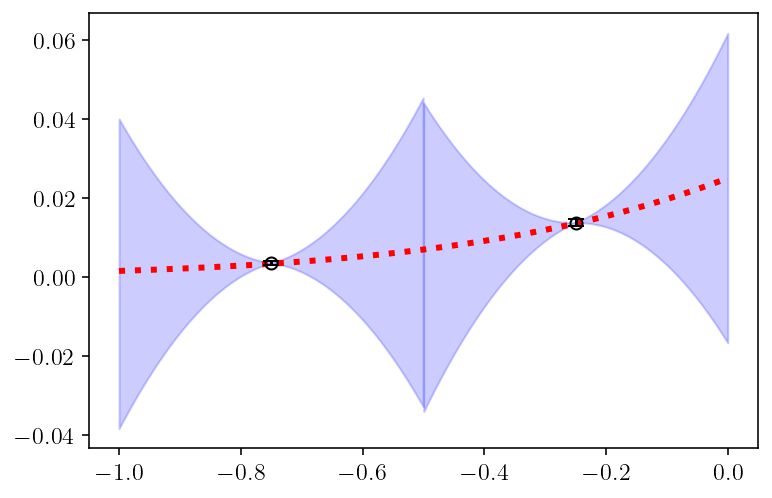

In [12]:
max_2nd_order = 0.5 * hess_bound * (xs - mu[closest_mu_idx]) ** 2

plt.plot(xs, true_err(xs), 'r:', linewidth=3)
plt.errorbar(
    mu,
    typeI_est,
    yerr=typeI_CI,
    ecolor="k",
    fmt="o",
    capsize=4,
    markeredgecolor="k",
    markerfacecolor="none",
)
bound_hi = typeI_est[closest_mu_idx] + max_1st_order + max_2nd_order
bound_lo = typeI_est[closest_mu_idx] + min_1st_order - max_2nd_order
for i in range(len(mu)):
    select = closest_mu_idx == i
    plt.fill_between(xs[select], bound_lo[select], bound_hi[select], color='b', alpha=0.2)
plt.show()

## A full CSE implementation for Z-test

Below, we use the same tools as above to make the paper figures!

In [13]:
z_thresh_default = -jax.scipy.stats.norm.ppf(0.025)
true_err = lambda mu: 1 - jax.scipy.stats.norm.cdf(-mu + z_thresh)

def ztest(npts=2, a=-1, b=0, z_thresh=z_thresh_default, delta=0.01, nsims=10000, seed=9, x=None):
    np.random.seed(seed)

    mu = np.linspace(a, b, 2 * npts + 1)[1::2]
    samples = mu[:, None] + np.random.normal(0, 1, size=(1, nsims))
    typeI_sum = np.sum(samples > z_thresh, axis=-1)
    typeI_est = typeI_sum / nsims
    grad_est = np.sum((samples > z_thresh) * (samples - mu[:, None]), axis=-1) / nsims

    typeI_CI = scipy.stats.beta.ppf(1 - delta, typeI_sum + 1, nsims - typeI_sum) - typeI_est
    grad_CI = np.sqrt((1 / delta) / nsims)
    hess_bound = 1.0
    
    if x is None:
        x = mu
    closest_mu_idx = np.abs(x[:, None] - mu[None, :]).argmin(axis=-1)

    v = x - mu[closest_mu_idx]
    grad_bounds = np.array([
        v * (grad_est[closest_mu_idx] + grad_CI),
        v * (grad_est[closest_mu_idx] - grad_CI)
    ])
    max_1st_order = np.max(grad_bounds, axis=0)
    min_1st_order = np.min(grad_bounds, axis=0)

    # NOTE: min_2nd_order = -max_2nd_order
    max_2nd_order = 0.5 * hess_bound * v ** 2

    full_max_bound = (typeI_est + typeI_CI)[closest_mu_idx] + max_1st_order + max_2nd_order
    full_min_bound = (typeI_est - typeI_CI)[closest_mu_idx] + min_1st_order - max_2nd_order
    
    return dict(
        mu=mu, 
        typeI_true=true_err(mu), 
        typeI_est=typeI_est, 
        typeI_CI=typeI_CI, 
        grad_est=grad_est, 
        grad_bound=grad_CI, 
        hess_bound=hess_bound,
        closest_mu_idx=closest_mu_idx,
        max_1st_order=max_1st_order,
        min_1st_order=min_1st_order,
        max_2nd_order=max_2nd_order,
        full_max_bound=full_max_bound,
        full_min_bound=full_min_bound
    )

## Figures!

In [14]:
def set_domain(skipx=False, skipy=False):
    if skipx:
        plt.tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )

    else:
        plt.xlabel("$\mu$")
        plt.xticks(np.linspace(-1, 0, 6))
    if skipy:
        plt.tick_params(
            axis="y", which="both", left=False, right=False, labelleft=False
        )
    else:
        yticks = np.linspace(0, 0.025, 6)
        plt.yticks(
            yticks,
            labels=[f"{(yv * 100):.1f}" for yv in yticks],
            rotation=45,
            ha="right",
        )
        plt.ylabel("\% Type I error")
    plt.axvline(x=0, color="k", linewidth=2, linestyle="-")
    plt.axhline(y=0.025, color="k", linewidth=2, linestyle="-")
    plt.xlim([-1.02, 0.05])
    plt.ylim([-0.001, 0.028])

def plot_power_pts(mu, t1_est, t1_CI=None):
    if t1_CI is None:
        plt.plot(mu, t1_est, "o")
    else:
        plt.errorbar(
            mu,
            t1_est,
            yerr=t1_CI,
            ecolor="k",
            fmt="o",
            capsize=4,
            markeredgecolor="k",
            markerfacecolor="none",
        )

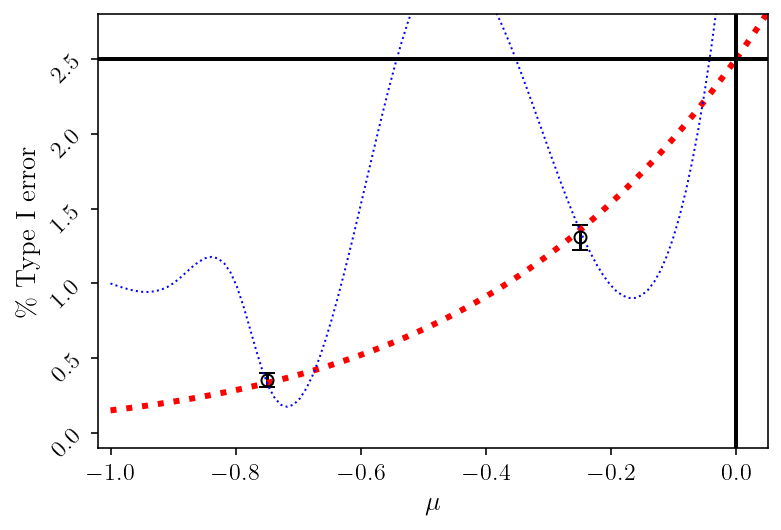

In [15]:
def fig1(include_ptwise_error, **kwargs):
    z = ztest(nsims=int(1e5))

    if include_ptwise_error:
        plot_power_pts(mu, z['typeI_est'], z['typeI_CI'])
    else:
        plot_power_pts(mu, z['typeI_true'])

    mu_dense10 = np.linspace(-1, 0, 100)
    pow_dense10 = true_err(mu_dense10)
    mu_dense01 = np.linspace(0, 1, 100)
    pow_dense01 = true_err(mu_dense01)
    plt.plot(mu_dense10, pow_dense10, "r:", linewidth=3)
    plt.plot(mu_dense01, pow_dense01, "r:", linewidth=3)

    mu_bad = np.append(z['mu'], [-1.1, -1.0, -0.9, -0.8, -0.5, 0.0])
    t1_bad = np.append(z['typeI_true'], [0.01, 0.01, 0.01, 0.01, 0.03, 0.04])
    interp_f = scipy.interpolate.interp1d(mu_bad, t1_bad, kind="cubic")
    plt.plot(mu_dense10, interp_f(mu_dense10), "b:", linewidth=1)
    set_domain(**kwargs)
fig1(True)

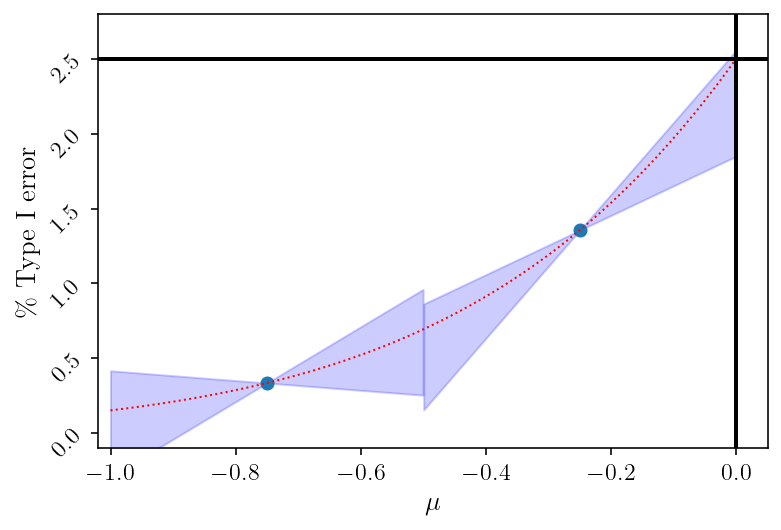

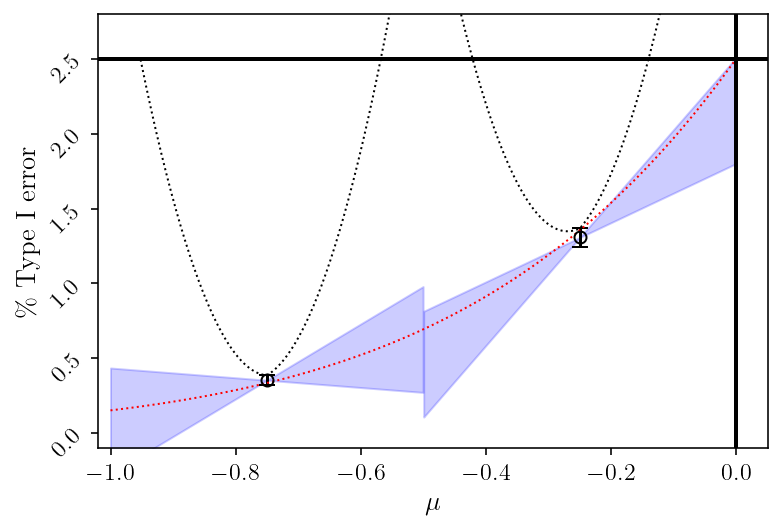

In [16]:
def fig2(include_0CI, include_quadratic, **kwargs):
    x = np.linspace(-1, 0, 1000)
    z = ztest(delta=0.05, x = x, nsims=int(1e5))

    if include_0CI:
        plot_power_pts(z['mu'], z['typeI_est'], z['typeI_CI'])
    else:
        plot_power_pts(z['mu'], z['typeI_true'])

    mu_dense10 = np.linspace(-1, 0, 100)
    pow_dense10 = true_err(mu_dense10)
    plt.plot(mu_dense10, pow_dense10, "r:", linewidth=1)

    if include_0CI:
        bound_hi = z['typeI_est'][z['closest_mu_idx']] + z['max_1st_order']
        bound_lo = z['typeI_est'][z['closest_mu_idx']] + z['min_1st_order']
        bound_hi += z['typeI_CI'][z['closest_mu_idx']]
        bound_hi -= z['typeI_CI'][z['closest_mu_idx']]
    else:
        bound_hi = z['typeI_true'][z['closest_mu_idx']] + z['max_1st_order']
        bound_lo = z['typeI_true'][z['closest_mu_idx']] + z['min_1st_order']
    for i in range(len(z['mu'])):
        select = z['closest_mu_idx'] == i
        plt.fill_between(x[select], bound_lo[select], bound_hi[select], color='b', alpha=0.2)

    if include_quadratic:
        filter = (x > -0.8) | (z['full_max_bound'] < 0.025)
        for i in range(len(z['mu'])):
            select = (z['closest_mu_idx'] == i) & filter
            plt.plot(x[select], z['full_max_bound'][select], 'k:', linewidth=1)
    set_domain(**kwargs)

fig2(False, False)
plt.show()
fig2(True, True)
plt.show()

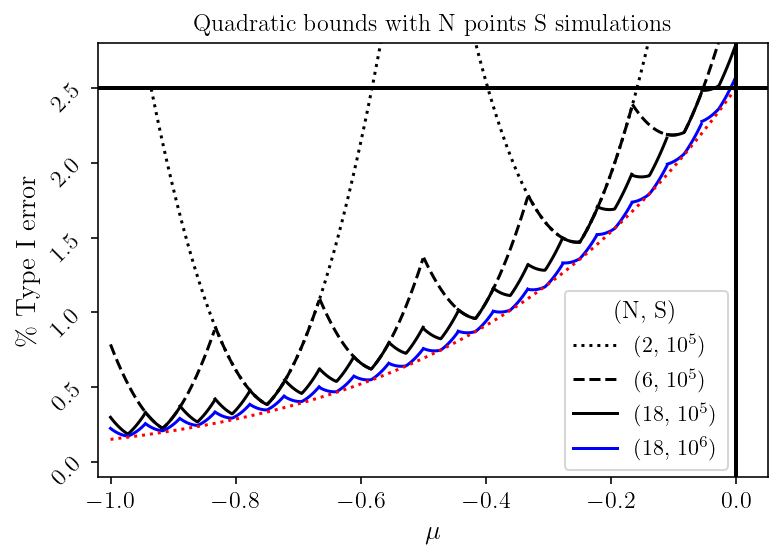

In [22]:
def fig3(npts = None, legend=True, **kwargs):
    if npts is None:
        npts = [2, 6, 18, 18]
    nsims = [int(1e5), int(1e5), int(1e5), int(1e6)]
    linestyle = ["k:", "k--", "k-", "b-"]
    x = np.linspace(-1, 0, 1000)
    for j in range(len(npts)):
        P = npts[j]
        label = f"({P}, $10^5$)" if j < 3 else f"({P}, $10^6$)"
        S = nsims[j]
        z = ztest(npts = P, nsims=S, delta=0.01, x = x, seed=13)

        filter = (x > -0.8) | (z['full_max_bound'] < 0.025)
        for i in range(len(z['mu'])):
            select = (z['closest_mu_idx'] == i) & filter
            plt.plot(x[select], z['full_max_bound'][select], linestyle[j], label=label if i == 0 else None)
    mu_dense10 = np.linspace(-1, 0, 100)
    pow_dense10 = true_err(mu_dense10)
    plt.plot(mu_dense10, pow_dense10, "r:")
    set_domain(**kwargs)
    if legend:
        plt.legend(loc=(0.697, 0.018), fontsize=11, title="(N, S)", title_fontsize=12)


fig3()
plt.title("Quadratic bounds with N points S simulations", fontsize=12)
plt.show()


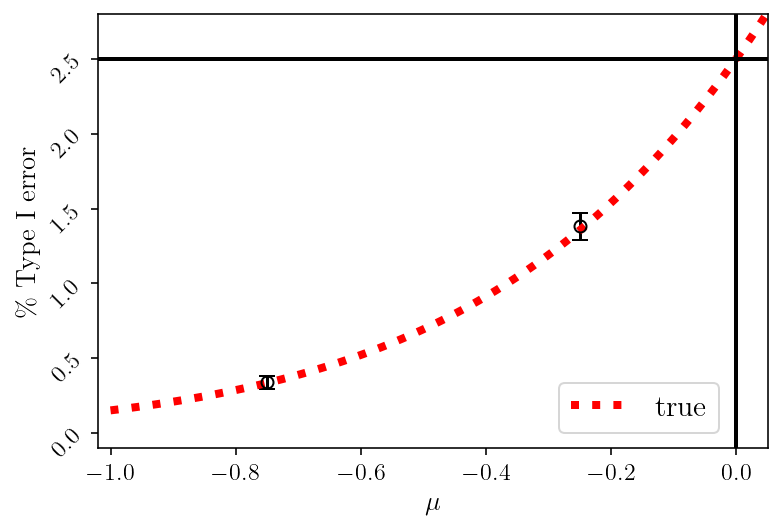

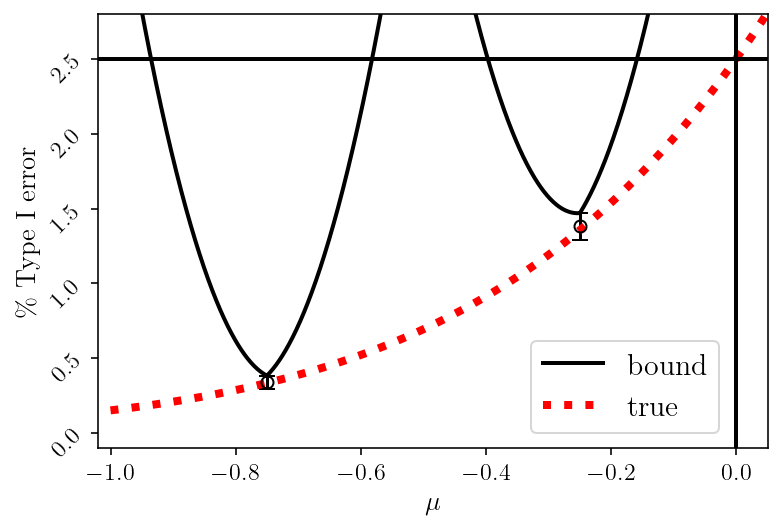

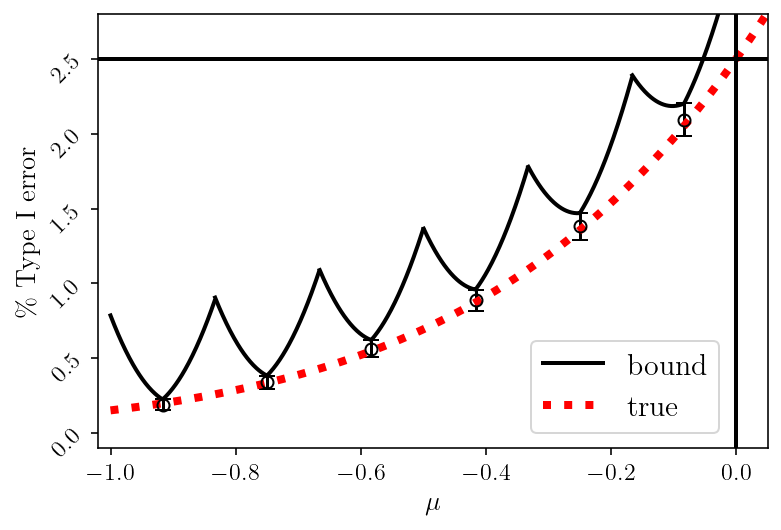

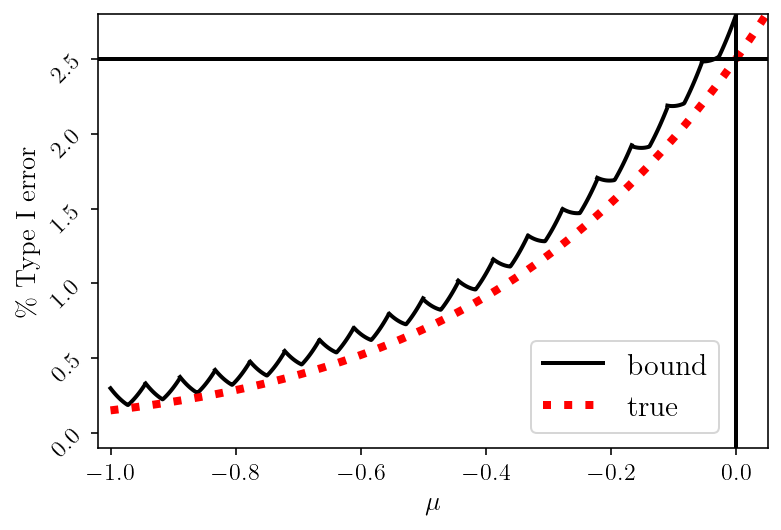

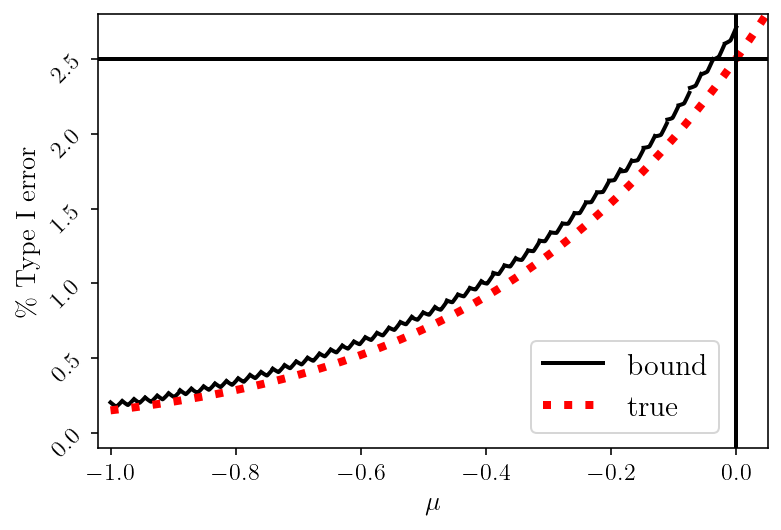

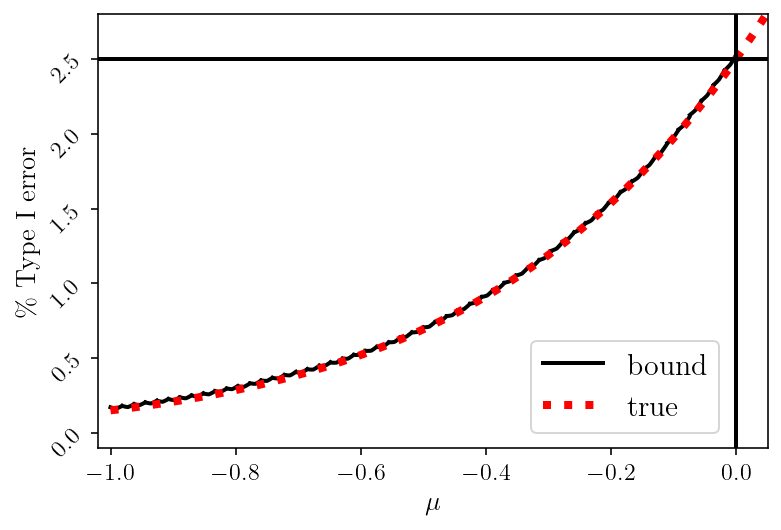

In [58]:
for fig_idx, npts in enumerate([[2], [2], [6], [18], [54], [54]]):
    # npts = [2]#, 6, 18, 18]
    nsims = [int(1e5)] if fig_idx <= 4 else [int(1e6)]
    # linestyle = ["k:", "k--", "k-", "b-"]
    linestyle=['k-']
    x = np.linspace(-1, 0, 1000)
    for j in range(len(npts)):
        P = npts[j]
        S = nsims[j]
        z = ztest(npts = P, nsims=S, delta=0.01, x = x, seed=13)

        if fig_idx <= 2:
            plt.errorbar(
                z['mu'],
                z['typeI_est'],
                yerr=z['typeI_CI'],
                ecolor="k",
                fmt="o",
                capsize=4,
                markeredgecolor="k",
                markerfacecolor="none",
            )

        if fig_idx > 0:
            for i in range(len(z['mu'])):
                select = (z['closest_mu_idx'] == i)
                plt.plot(x[select], z['full_max_bound'][select], linestyle[j], linewidth=2, label='bound' if i == 0 else None)
    mu_dense10 = np.linspace(-1, 0, 100)
    pow_dense10 = true_err(mu_dense10)
    plt.plot(mu_dense10, pow_dense10, "r:", linewidth=4, label='true')
    mu_dense01 = np.linspace(0, 1, 100)
    pow_dense01 = true_err(mu_dense01)
    plt.plot(mu_dense01, pow_dense01, "r:", linewidth=4)
    set_domain()
    plt.savefig(f"bayes2022_z{fig_idx}.png", dpi=300, bbox_inches="tight")
    plt.legend(loc='lower right', bbox_to_anchor=(0.95, 0.0))
    plt.show()

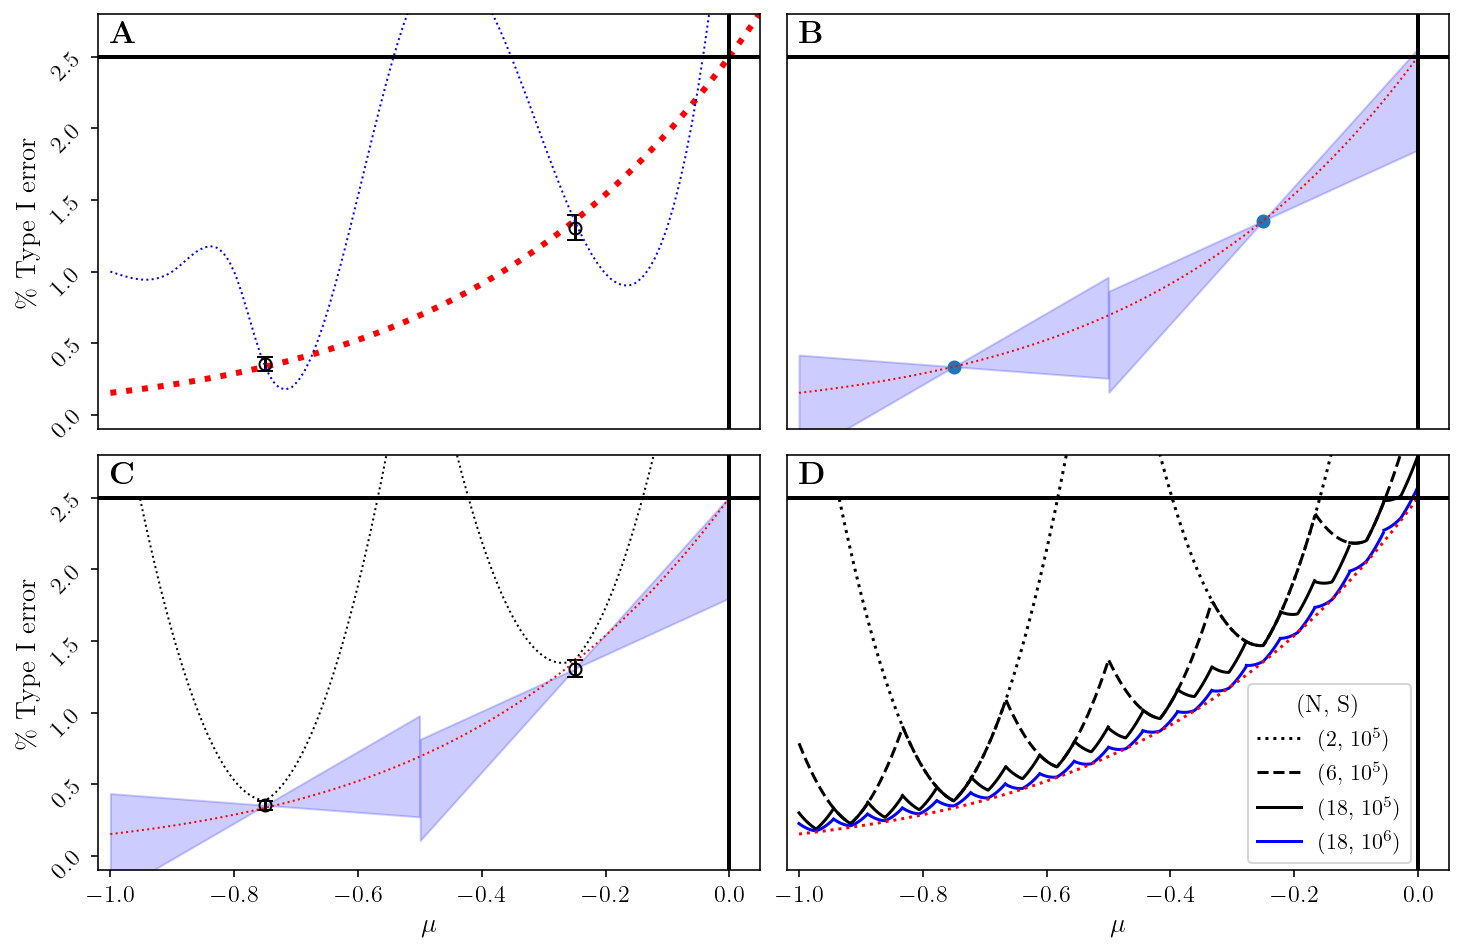

In [18]:
%matplotlib inline
import matplotlib.patches as patches

ratio = 8.5 / 5.5
h = 6.5
plt.figure(figsize=(ratio * h, h), constrained_layout=True)
plt.subplot(2, 2, 1)
fig1(True, skipx=True)
plt.text(-1, 0.026, "$\mathbf{A}$", fontsize=16)
plt.subplot(2, 2, 2)
fig2(False, False, skipx=True, skipy=True)
plt.text(-1, 0.026, "$\mathbf{B}$", fontsize=16)
plt.subplot(2, 2, 3)
fig2(True, True)
plt.text(-1, 0.026, "$\mathbf{C}$", fontsize=16)
plt.subplot(2, 2, 4)
fig3(skipy=True)
t = plt.text(-1, 0.026, "$\mathbf{D}$", fontsize=16)
plt.savefig("ztest-four-panels.pdf", bbox_inches="tight")
plt.show()


In [19]:
z_thresh_default = -jax.scipy.stats.norm.ppf(0.025)
true_err = lambda mu, z_thresh: 1 - jax.scipy.stats.norm.cdf(-mu + z_thresh)

def ztest(npts=2, a=-1, b=0, z_thresh=z_thresh_default, delta=0.01, nsims=10000, seed=9, x=None):
    np.random.seed(seed)

    mu = np.linspace(a, b, 2 * npts + 1)[1::2]
    samples = mu[:, None] + np.random.normal(0, 1, size=(1, nsims))
    typeI_sum = np.sum(samples > z_thresh, axis=-1)
    typeI_est = typeI_sum / nsims
    grad_est = np.sum((samples > z_thresh) * (samples - mu[:, None]), axis=-1) / nsims

    typeI_CI = scipy.stats.beta.ppf(1 - delta, typeI_sum + 1, nsims - typeI_sum) - typeI_est
    grad_bound = np.sqrt((1 / delta - 1) / nsims)
    hess_bound = 1.0
    
    if x is None:
        x = mu
    closest_mu_idx = np.abs(x[:, None] - mu[None, :]).argmin(axis=-1)

    v = x - mu[closest_mu_idx]
    grad_bounds = np.array([
        v * (grad_est[closest_mu_idx] + grad_bound),
        v * (grad_est[closest_mu_idx] - grad_bound)
    ])
    max_1st_order = np.max(grad_bounds, axis=0)
    min_1st_order = np.min(grad_bounds, axis=0)

    # NOTE: min_2nd_order = -max_2nd_order
    max_2nd_order = 0.5 * hess_bound * (x - mu[closest_mu_idx]) ** 2

    full_max_bound = (typeI_est + typeI_CI)[closest_mu_idx] + max_1st_order + max_2nd_order
    full_min_bound = (typeI_est - typeI_CI)[closest_mu_idx] + min_1st_order - max_2nd_order
    
    return dict(
        mu=mu, 
        typeI_true=true_err(mu, z_thresh), 
        typeI_est=typeI_est, 
        typeI_CI=typeI_CI, 
        grad_est=grad_est, 
        grad_bound=grad_bound, 
        hess_bound=hess_bound,
        closest_mu_idx=closest_mu_idx,
        max_1st_order=max_1st_order,
        min_1st_order=min_1st_order,
        max_2nd_order=max_2nd_order,
        full_max_bound=full_max_bound,
        full_min_bound=full_min_bound
    )

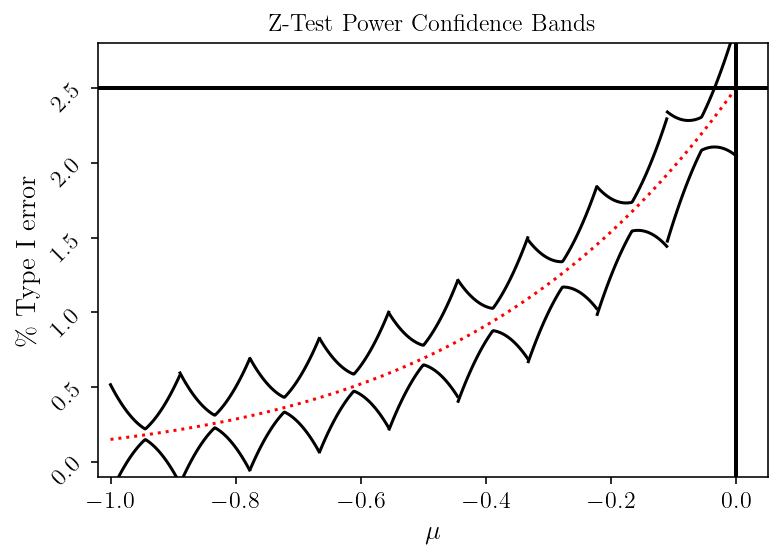

In [20]:
def fig5(z_thresh, seed, **kwargs):
    linestyle = ["k-"]
    x = np.linspace(-1, 0, 1000)
    z = ztest(z_thresh=z_thresh, npts = 9, nsims=int(1e5), delta=0.01, x = x, seed=seed)

    for i in range(len(z['mu'])):
        select = z['closest_mu_idx'] == i
        plt.plot(x[select], z['full_max_bound'][select], 'k-')
        plt.plot(x[select], z['full_min_bound'][select], 'k-')
    mu_dense10 = np.linspace(-1, 0, 100)
    pow_dense10 = true_err(mu_dense10, z_thresh)
    plt.plot(mu_dense10, pow_dense10, "r:")
    set_domain(**kwargs)


fig5(1.96, 12)
plt.title("Z-Test Power Confidence Bands", fontsize=12)
plt.savefig("power-ztest.pdf", bbox_inches="tight")
plt.show()

# fig5(2.04, 12)
# plt.title("CSE-Tuned Z-Test Power Confidence Bands", fontsize=12)
# plt.savefig("tuned-ztest.pdf", bbox_inches="tight")
# plt.show()

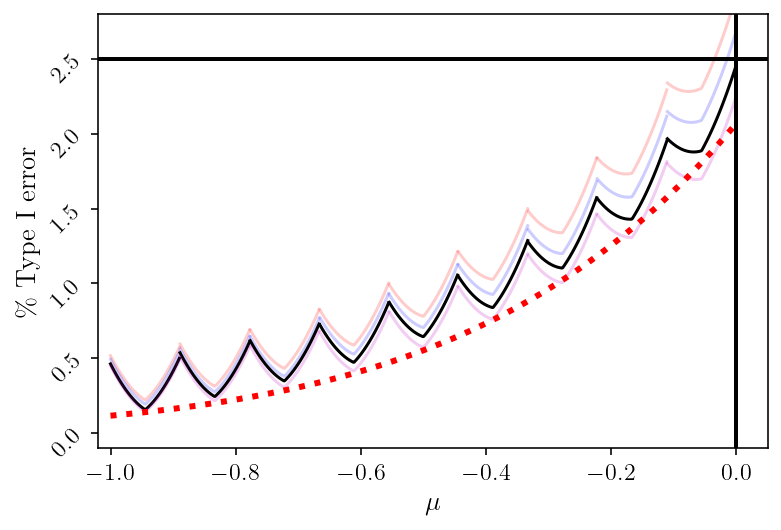

In [21]:
linestyle = ["k-"]
x = np.linspace(-1, 0, 1000)
for j, z_thresh in enumerate(np.linspace(1.96, 2.08, 4)):
    pick = z_thresh == 2.04
    z = ztest(z_thresh=z_thresh, npts=9, nsims=int(1e5), delta=0.01, x=x, seed=12)

    for i in range(len(z["mu"])):
        select = z["closest_mu_idx"] == i
        plt.plot(
            x[select],
            z["full_max_bound"][select],
            alpha=1.0 if pick else 0.2,
            color="k" if pick else ["r", "b", "g", "m"][j],
        )
        # skip the lower bound
        # plt.plot(x[select], z['full_min_bound'][select], alpha = 1.0 if pick else 0.3, color = "k" if pick else None)
mu_dense10 = np.linspace(-1, 0, 100)
pow_dense10 = true_err(mu_dense10, 2.04)
plt.plot(mu_dense10, pow_dense10, "r:", linewidth=3)

set_domain()
plt.savefig("tuned-ztest.pdf", bbox_inches="tight")
plt.show()

In [22]:
mu_dense10[-1], pow_dense10[-1]

(0.0, DeviceArray(0.02067516, dtype=float64))

In [23]:
import numpy as np
x = np.array([0.0])
npts = [5, 10, 20, 40, 80]
nsims = [2500, 10000, 40000, 90000, 160000, 250000, 360000]
bound0 = np.empty((len(npts), len(nsims)))
for i, P in enumerate(npts):
    for j, S in enumerate(nsims):
        z = ztest(z_thresh=1.96, npts = int(P), nsims=int(S), delta=0.01, x = x, seed=12)
        bound0[i, j] = z['full_max_bound'][0]

In [24]:
z = ztest(z_thresh=1.96, npts = 200, nsims=int(1e6), delta=0.01, x = x, seed=12)
z['full_max_bound'][0] - 0.025

0.00020564090532306997

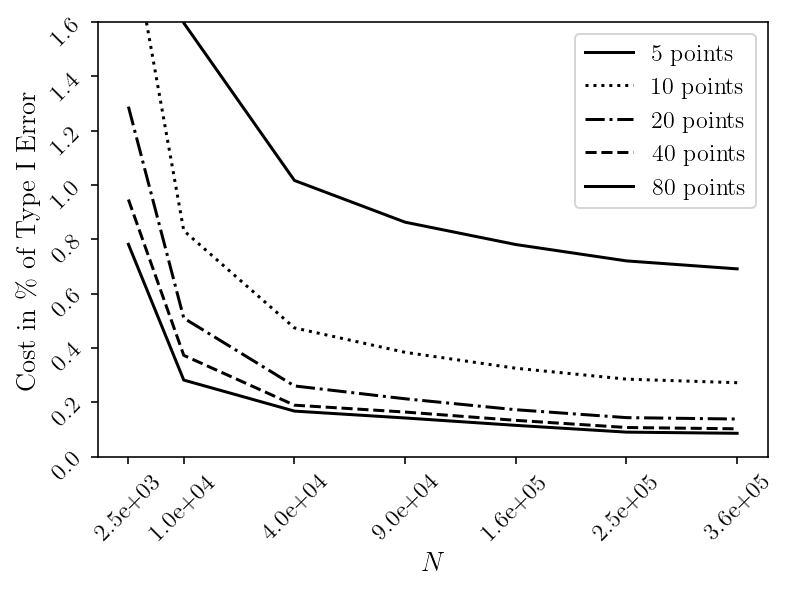

In [25]:
styles = ['k-', 'k:', 'k-.', 'k--', 'k-', 'k:']
for i in range(len(npts)):
    plt.plot(np.sqrt(nsims), bound0[i, :] - 0.025, styles[i], label = f'{npts[i]:.0f} points')
plt.legend(fontsize=12)
plt.ylim([0, 0.016])
plt.ylabel('Cost in \% of Type I Error')
yticks = np.linspace(0, 0.016, 9)
plt.yticks(
    yticks,
    labels=[f"{(yv * 100):.1f}" for yv in yticks],
    rotation=45,
    ha="right",
)
plt.xticks(np.sqrt(nsims), rotation=45)
plt.gca().set_xticklabels([f'{x:.1e}' for x in nsims])
plt.xlabel('$N$')
plt.savefig("z-test-cost.pdf", bbox_inches="tight")
plt.show()